In [1]:
# Version: 0.0.1
# Date:    2022-07-22
# Author:  P. J. Vetter, Timo Joas
# Email=  philipp.vetter@uni-ulm.de;

In [2]:
# Simulation to investigate the robustness of the optimal control pulse. 
# Pulse units are abstracted away by imported ArbPulse class

# The oc_element function reads in the pulse files and creates the corresponding pulse

# all possible initial states are defined in the 'Initial State' section
# density matrix of the m_s = 0 state: rho_ms0 
# density matrix of the m_s = -1 state: rho_msm1
# density matrix of the x state: rho_x
# density matrix of the y state: rho_y

# (The first run might take a bit longer due to the plot generation)

# Packages

In [268]:
import os
os.getcwd()

'C:\\Users\\Setup3-PC\\Desktop\\qudi\\user_scripts\\Timo\\own\\optimalcontrol'

In [269]:
#%matplotlib notebook
#%matplotlib notebook

import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from scipy import interpolate
import matplotlib as mpl

from oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

plt.rcParams.update({'font.size': 30})  
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Library

In [270]:
def get_f_limits(f_res, f_center_block, df, symm_block=False):
    f_center_block_mhz = f_center_block*1e-6
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    freqs = []
    if symm_block:
        delta_block = f_center_block_mhz - f_res_mhz
        f_center_2_mhz = f_res_mhz - delta_block
        f_centers = [f_center_block_mhz, f_center_2_mhz]
    else:
        f_centers = [f_center_block_mhz]
    for f in f_centers:
        freqs.append([1e6*(f-df_mhz), 1e6*(f+df_mhz)])
    return freqs
    
def calc_crosstalk_penalty(freqs, spin_pop, f_res, f_center_block, df, symm_block=False, fac_penalty=1):

    
    idxs = np.empty((0), dtype=int)
    for (f_min, f_max) in get_f_limits(f_res, f_center_block, df, symm_block=symm_block):      
        idxs = np.append(idxs, np.where(np.logical_and(freqs >= f_min, freqs <= f_max)))
    
    #return idxs
    spin_pop = np.mean(spin_pop[idxs])
    
    # as in optimalcontrol_quocs.ipynb
    fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
    
    return fom_sim

def partial_trace(rho, sub=0, dims=None):
    if dims is None:
        dims = [[2,2],[2,2]]
    return np.asarray(qutip.Qobj(rho, dims=dims).ptrace(sub))    

def swap_basis_def(rho):
    # Genkos state definition is different!
    return np.rot90(rho,2).T

In [271]:
# shaddowed from Phlilip V.

def calc_chi(rho0_chi,rho1_chi,rho2_chi,rho3_chi):
    #"Quantum State Tomography: calculate matrix Chi from given density matrices rho1,..,rho4"
    sigx = np.array([[0,1],[1,0]])

    #Defintion of Matrix M

    M=np.zeros([8,8],dtype=complex)
    M[0,0]=0
    M[0,1]=0
    M[0,2]=0
    M[0,3]=0
    M[0,4]=0
    M[0,5]=0
    M[0,6]=1
    M[0,7]=0

    M[1,0]=0
    M[1,1]=0
    M[1,2]=0
    M[1,3]=0
    M[1,4]=0
    M[1,5]=0
    M[1,6]=0
    M[1,7]=1

    M[2,0]=1
    M[2,1]=0
    M[2,2]=0
    M[2,3]=0
    M[2,4]=0
    M[2,5]=0
    M[2,6]=0
    M[2,7]=0

    M[3,0]=0
    M[3,1]=1
    M[3,2]=0
    M[3,3]=0
    M[3,4]=0
    M[3,5]=0
    M[3,6]=0
    M[3,7]=0

    M[4,0]=0.5
    M[4,1]=0
    M[4,2]=-0.5j
    M[4,3]=0
    M[4,4]=0.5j
    M[4,5]=0
    M[4,6]=0.5
    M[4,7]=0

    M[5,0]=0
    M[5,1]=0.5
    M[5,2]=0
    M[5,3]=-0.5j
    M[5,4]=0
    M[5,5]=0.5j
    M[5,6]=0
    M[5,7]=0.5

    M[6,0]=0.5
    M[6,1]=0
    M[6,2]=-0.5
    M[6,3]=0
    M[6,4]=-0.5
    M[6,5]=0
    M[6,6]=0.5
    M[6,7]=0

    M[7,0]=0
    M[7,1]=0.5
    M[7,2]=0
    M[7,3]=-0.5
    M[7,4]=0
    M[7,5]=-0.5
    M[7,6]=0
    M[7,7]=0.5

    #calculate inverse of matrix M
    Minv = np.linalg.inv(M)
    
    #convert matrices rho1,...,rho4 to one 8x2 matrix
    rho_chi=np.zeros([8,2],dtype=complex)
    rho_chi[0,0]=rho0_chi[0,0]
    rho_chi[0,1]=rho0_chi[0,1]
    rho_chi[1,0]=rho0_chi[1,0]
    rho_chi[1,1]=rho0_chi[1,1]

    rho_chi[2,0]=rho1_chi[0,0]
    rho_chi[2,1]=rho1_chi[0,1]
    rho_chi[3,0]=rho1_chi[1,0]
    rho_chi[3,1]=rho1_chi[1,1]

    rho_chi[4,0]=rho2_chi[0,0]
    rho_chi[4,1]=rho2_chi[0,1]
    rho_chi[5,0]=rho2_chi[1,0]
    rho_chi[5,1]=rho2_chi[1,1]

    rho_chi[6,0]=rho3_chi[0,0]
    rho_chi[6,1]=rho3_chi[0,1]
    rho_chi[7,0]=rho3_chi[1,0]
    rho_chi[7,1]=rho3_chi[1,1]
    
    #Minv times rho
    rhoprime = np.matmul(Minv,rho_chi)
    #convert rhoprime (8x2) into a 4x4 matrix
    rhoM=np.zeros([4,4],dtype=complex)
    rhoM[0:2,0:2]=rhoprime[0:2,0:2]
    rhoM[0:2,2:4]=rhoprime[2:4,0:2]
    rhoM[2:4,0:2]=rhoprime[4:6,0:2]
    rhoM[2:4,2:4]=rhoprime[6:9,0:2]
    
    #Definition of Lambda
    Lambda=np.zeros([4,4],dtype=complex)
    Lambda[0:2,0:2]=np.identity(2)
    Lambda[2:4,0:2]=sigx
    Lambda[0:2,2:4]=sigx
    Lambda[2:4,2:4]=-np.identity(2)
    Lambda = Lambda * 0.5
    
    #calculate Chi
    chi = np.matmul(Lambda,np.matmul(rhoM,Lambda))                    
    
    return chi


# Variables

In [6]:
# magnetic field [G]
B = 90

## Load pulses

In [272]:



folder = r"input_pulses\rect"
name = "rec_amp_20MHz_0.025mus_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='µs', unit_data='MHz')

#folder = r"input_pulses"
#name = "on_nv=2_"

folder = r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
name = "opt_res_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*20,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*20))

folder = r"input_pulses\20220729_1_guessFromReisserMsc_penalty_fac=100"
name = "opt_res_"
name = "opt_res_"
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*20,
                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*20))


folder = r"C:\Software\qudi_data\optimal_control_assets\20220818_procTomo_fromWeak_1"
fname = r"opt_res_"
pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*25,
                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*25))

#folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
#name = "Opt_Pulse_01_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='ns', unit_data='MHz')


# loading experimental pulse
# 0.25 = 20 MHz
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s',  func_ampl_v_2_omega_mhz=lambda x: x/0.25*20)


#pulse = TimeDependentSimulation.load_pulse(folder, name, func_t_2_us=lambda t: t*1e6)
#
pulse.as_dict()




{'name': 'opt_res_',
 'folder': 'C:\\Software\\qudi_data\\optimal_control_assets\\20220818_procTomo_fromWeak_1',
 'file': ['C:\\Software\\qudi_data\\optimal_control_assets\\20220818_procTomo_fromWeak_1\\opt_res_amplitude.txt',
  'C:\\Software\\qudi_data\\optimal_control_assets\\20220818_procTomo_fromWeak_1\\opt_res_phase.txt'],
 'timegrid_unit': 's',
 'data_unit': 'V',
 'data_ampl': array([0.027, 0.028, 0.028, ..., 0.064, 0.064, 0.063]),
 'data_phase': array([0.07 , 0.07 , 0.07 , ..., 0.065, 0.065, 0.064]),
 'timegrid_ampl': array([0., 0., 0., ..., 0., 0., 0.]),
 'timegrid_phase': array([0., 0., 0., ..., 0., 0., 0.])}

In [254]:
pulse.as_dict()

{'name': 'on_nv=2_',
 'folder': 'C:\\Software\\qudi_data\\optimal_control_assets',
 'file': ['C:\\Software\\qudi_data\\optimal_control_assets\\on_nv=2_amplitude.txt',
  'C:\\Software\\qudi_data\\optimal_control_assets\\on_nv=2_phase.txt'],
 'timegrid_unit': 's',
 'data_unit': 'V',
 'data_ampl': array([0.026, 0.027, 0.027, ..., 0.063, 0.063, 0.062]),
 'data_phase': array([0.069, 0.069, 0.069, ..., 0.066, 0.066, 0.066]),
 'timegrid_ampl': array([0., 0., 0., ..., 0., 0., 0.]),
 'timegrid_phase': array([0., 0., 0., ..., 0., 0., 0.])}

In [7]:
len(pulse.as_dict()['timegrid_ampl'])

2000

## Generate pulses

In [217]:

pulse = PredefinedArbPulses.generate_levitt(20e6, phase=0)
pulse = PredefinedArbPulses.generate_rect_pi(20e6, phase=np.pi/2)
pulse = PredefinedArbPulses.generate_rect_pi(20e6, phase=0)

#pulse['data_phase']
#val_i, val_q = np.asarray([1,0])*1
#np.asarray([np.pi/2, 0, np.pi/2]) + 0

#data_ampl = np.asarray([0,0,0])
#data_ampl[0:3] = 1
#data_ampl

## Plot pulses

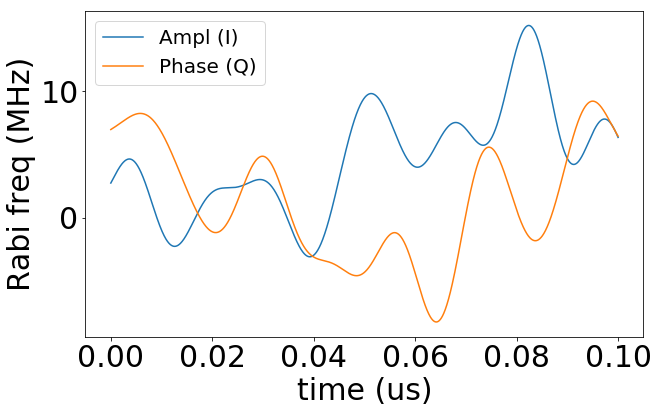

In [273]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='µs')
amplitude = pulse.get_data_ampl(unit='MHz')
t_phase = pulse.get_timegrid(unit='µs')
phase = pulse.get_data_phase(unit='MHz')

try:
    plt.figure(figsize=(10,6))
    plt.plot(t_amplitude, amplitude, label="Ampl (I)")
    plt.plot(t_phase, phase, label="Phase (Q)")
   # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.ylabel("Rabi freq (MHz)")
    plt.xlabel("time (us)")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")

# Parameters, Operators

In [274]:

simp = SimParameters()
simp.dims = simp.S_x.dims   # temp, can delete

# Measurements

Single simulation without error

In [260]:
rho = run_sim(None, pulse, B, simp)
sig_z = np.trace(np.matmul(rho, simp.P_nv))

rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
rho
rho_nv

array([[ 0.105+0.j   , -0.085+0.126j],
       [-0.085-0.126j,  0.895+0.j   ]])

Init and read in X,Y

In [261]:
import scipy

u_init = 2*simp.S_x    # pi_X, 0->1, pulse on NV, 1 on 14-N
#u_init = scipy.linalg.sqrtm(2*simp.S_y)     # pi2_Y, 0->X, pulse on NV, 1 on 14-N
u_init = scipy.linalg.sqrtm(2*simp.S_x)      # pi2_Y, 0->-Y, pulse on NV, 1 on 14-N
#u_init = None       # init = 0

#vec_init = simp.

rho = run_sim(None, pulse, B, simp, nv_init_ux=u_init, nv_read_ux=u_init)
rho_nv = partial_trace(rho, sub=0, dims=simp.dims)

rho_nv
#u_init

array([[0.945-0.j   , 0.049-0.047j],
       [0.049+0.047j, 0.055+0.j   ]])

## Simulated process tomography

In [276]:
def run_sim(self, pulse, B_gauss, sim_params, nv_init_ux=None, nv_read_ux=None,
                  n_timebins=500, t_idle_extension=-1e-9):

    # for compability reason, accept pulse as dict or ArbPulse object
    # if supplying a dict, you are responsible for correct units!
    if type(pulse) == ArbPulse:
        pulse.set_unit_time('µs')
        pulse.set_unit_data('MHz')
        pulse = pulse.as_dict()

    B = B_gauss
    simp = sim_params
    oc_length = pulse['timegrid_ampl'][-1] + t_idle_extension*1e6

    t = np.linspace(0, oc_length, n_timebins)
    options=qutip.Options(atol=1e-15, rtol=1e-15, nsteps=1e8, store_final_state=True)

    init_state = simp.rho_ms0
    if nv_init_ux is not None:
        u = np.asarray(nv_init_ux)
        init_state = np.matmul(np.matmul(u,init_state),u.conj().T)
        init_state = qutip.Qobj(init_state, dims=sim_params.dims)
    
    freq = simp.D - simp.gamma_nv * B 
    
    # perform the measurement
    oc_el = TimeDependentSimulation.oc_element(t, pulse['timegrid_ampl'], pulse['data_ampl'], pulse['data_phase'],
                                               freq, B, 1, simp)
    results_measurement = qutip.mesolve(oc_el, init_state, t, [], [simp.P_nv],
                                            options=options, progress_bar=None)
    
    rho_final = results_measurement.final_state
    if nv_read_ux is not None:
        u = np.asarray(nv_read_ux)
        rho_final = np.matmul(np.matmul(u,rho_final),u.conj().T)
        rho_final = qutip.Qobj(rho_final, dims=sim_params.dims)
    
    return rho_final


If needed: swap pulse phase from X<->Y

In [265]:
import copy as cp

d_i, d_q = cp.copy(pulse._data_ampl), cp.copy(pulse._data_phase)
pulse._data_ampl = d_q
pulse._data_phase = d_i

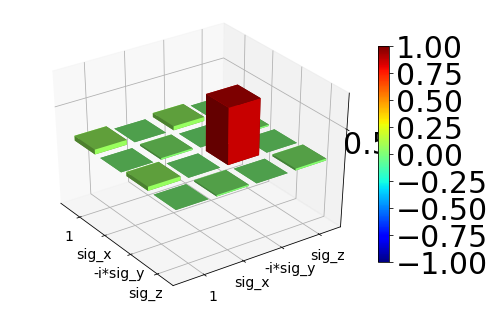

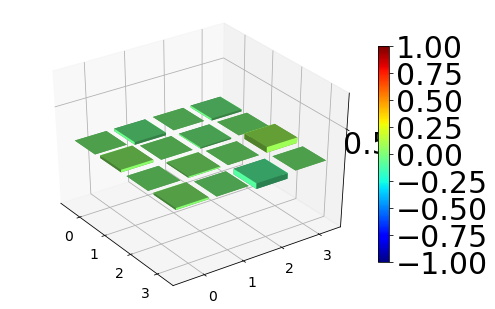

array([[ 0.075+0.j   ,  0.   -0.04j ,  0.063-0.j   ,  0.   -0.03j ],
       [ 0.   +0.04j ,  0.025+0.j   , -0.   -0.019j,  0.022+0.j   ],
       [ 0.063+0.j   , -0.   +0.019j,  0.87 +0.j   ,  0.   +0.086j],
       [ 0.   +0.03j ,  0.022-0.j   ,  0.   -0.086j,  0.03 +0.j   ]])

In [275]:
# debug



rhos = []
# convention in calc_chi: [1, pix, pi2x, pi2y]
us_init = [None, 2*simp.S_x, scipy.linalg.sqrtm(2*simp.S_x) , scipy.linalg.sqrtm(2*simp.S_y)]

for u_x in us_init:
    rho = run_sim(None, pulse, B, simp, nv_init_ux=u_x, nv_read_ux=None)
    rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
    rho_nv = swap_basis_def(rho_nv)  # basis definition in Philip V. code is different
    
    rhos.append(rho_nv)

chi_tomo = calc_chi(rhos[0], rhos[1], rhos[2], rhos[3])

qutip.matrix_histogram(np.real(chi_tomo), limits=[-1,1],
                       xlabels=["1", "sig_x", "-i*sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "-i*sig_y", "sig_z"])
plt.show()
qutip.matrix_histogram(np.imag(chi_tomo), limits=[-1,1])
plt.show()

chi_tomo

## Frequency Detuning

In [129]:

B = 86.07
df = 125#120#120 # MHz

f_block = 2710 # MHz
df_block = 10
symm_block = True
fac_penalty = 100
f_mw = simp.gamma_nv * B
B_nv2 = (2870-f_block)/simp.gamma_nv

n_f = np.min([int(df/0.25), 500])
n_f= 25



sim = TimeDependentSimulation()

freq_array = np.linspace(simp.D - simp.gamma_nv * B - df, simp.D - simp.gamma_nv * B + df, n_f)
#freq_array = np.linspace(3000, 3200, n_f)
#freq_array = np.linspace(2000, 3200, n_f)

#freq_array = np.linspace(2710-10, 2710+10, 50)
data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B, simp)
#data_freq_detuning = run_sim_fsweep(None, freq_array, pulse, B, simp)
penalty = calc_crosstalk_penalty(1e6*freq_array, data_freq_detuning, 1e6*f_mw, 1e6*f_block, 1e6*df_block,
                                 symm_block=symm_block, fac_penalty=fac_penalty)


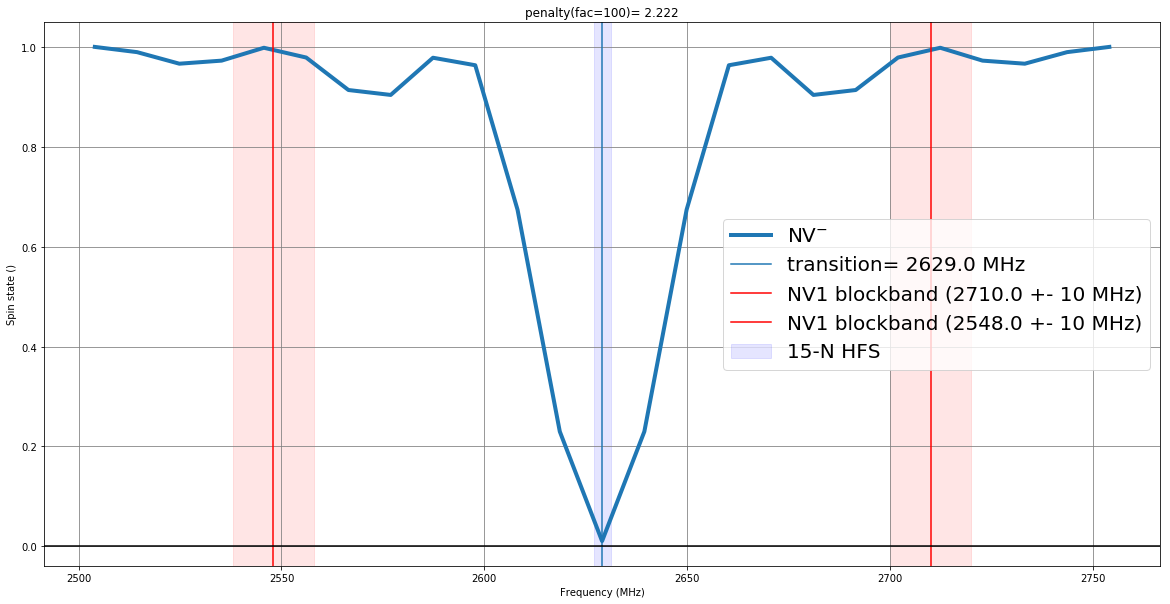

In [130]:
f_mw = simp.D - simp.gamma_nv * B

title_str = ""

# visualize the results
fig1, ax = plt.subplots(figsize=(20,10))
ax.plot(freq_array, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(freq_array+2*(B-B_nv2)/2*simp.gamma_nv, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(f_exp_mhz, y_exp, label="exp")
#ax.plot(f_exp_mhz_mirr, y_exp, label="mirrored(exp)")
#ax.set_xlim([2603,2653])

ax.axvline(f_mw, label=f"transition= {f_mw:.1f} MHz")
ax.axvspan(f_mw-2.1, f_mw+2.1, alpha=0.1, color='blue', label='15-N HFS')


# blockbands
f_lims = get_f_limits(1e6*f_mw, 1e6*f_block, 1e6*df_block, symm_block=symm_block)
for f_min, f_max in f_lims:
    f_center = (f_max + f_min) / 2
    if 1e-6*f_center > freq_array[0] and 1e-6*f_center < freq_array[-1]: 
        ax.axvline(1e-6*f_center, label=f"NV1 blockband ({1e-6*f_center:.1f} +- {df_block} MHz)", color='red')
        ax.axvspan(1e-6*f_min, 1e-6*f_max, alpha=0.1, color='red')

title_str += f"penalty(fac={fac_penalty})= {penalty:.3f}"
        
# grid
ax.axhline(0, color='black')
#ax.axhline(1, color='black')
plt.grid(axis='x', color='0.5')
plt.grid(axis='y', color='0.5')




ax.set_xlabel(r'Frequency (MHz)')
ax.set_ylabel(r'Spin state ()')
plt.title(title_str)
ax.legend(loc='best', prop={'size': 20})
plt.show(fig1)

## Amplitude Error

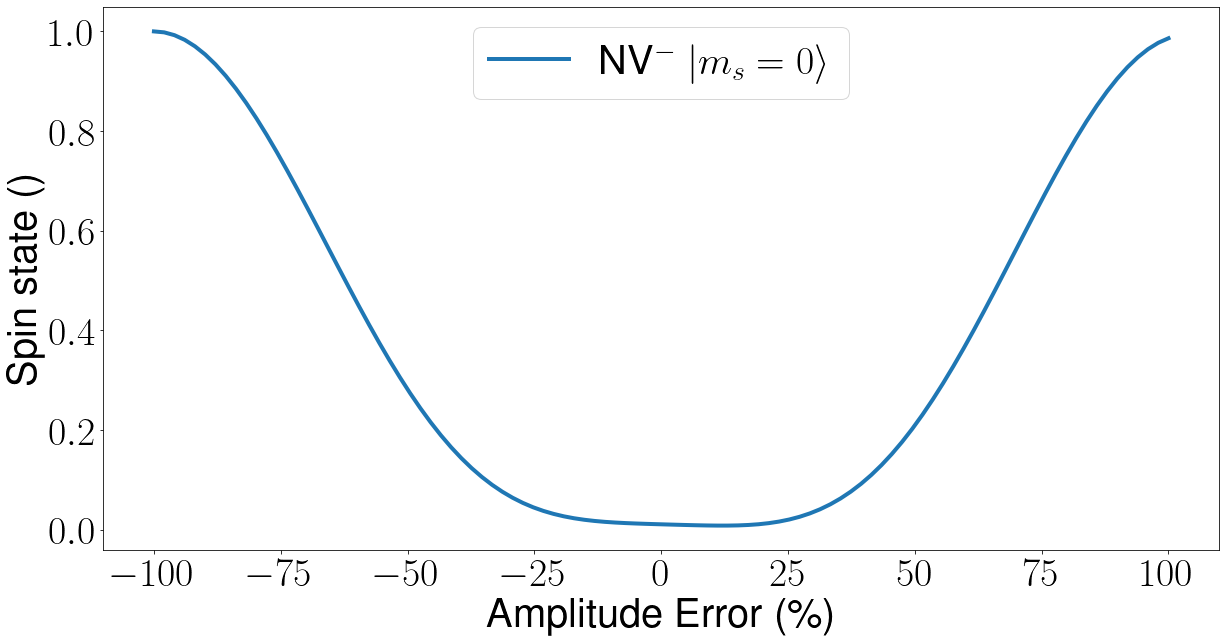

In [10]:
B= 90 #gauss

sim = TimeDependentSimulation()

# scanned amplitude steps
amp_array = np.linspace(-1, 1, 100)
data_amp_detuning = sim.run_sim_ampsweep(amp_array, pulse, B, simp)

# visualize the results
fig2, ax = plt.subplots(figsize=(20,10))
ax.plot(amp_array*100, data_amp_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
ax.set_xlabel(r'Amplitude Error (\%)')
ax.set_ylabel(r'Spin state ()')
ax.legend(loc='best')
plt.show(fig2) 